In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import math 

import os
import sys

import pandas as pd

import pandas as pd
import seaborn as sns
import h5py

from tqdm import tqdm
import pickle
%matplotlib inline

In [2]:
subject = "2"

In [4]:
COCO_ROOT = '/gpfs01/bartels/user/hbhatnagar/coco/panoptic_annotations_trainval2017'
NSD_ROOT  = "/gpfs01/bartels/user/hbhatnagar/NSD_dataset/"
STIM_ROOT  = NSD_ROOT + "nsddata_stimuli/stimuli/nsd/"

stim_file = STIM_ROOT + "nsd_stimuli.hdf5"
exp_design_file = NSD_ROOT + "nsddata/experiments/nsd/nsd_expdesign.mat"
nsd_stiminfo_file = '/gpfs01/bartels/user/hbhatnagar/NSD_dataset/nsddata/experiments/nsd/nsd_stim_info_merged.pkl'

PRF_PATH = NSD_ROOT+'nsddata/ppdata/' 
DATA_PATH = "/gpfs01/bartels/user/hbhatnagar/nsd-static-saliency/data"
BETAS_PATH = NSD_ROOT+f"/nsddata_betas/ppdata/subj0{subject}/func1pt8mm/betas_fithrf_GLMdenoise_RR/"
BEHAV_PATH = NSD_ROOT + f"/nsddata/ppdata/subj0{subject}/behav/responses.tsv"

DEVICE = 'cpu'

In [5]:
def behav_file_subjectwise(subject):
    BEHAV_PATH = NSD_ROOT + f"/nsddata/ppdata/subj0{subject}/behav/responses.tsv"
    resp_subj = pd.read_csv(BEHAV_PATH, sep ='\t')

    # since it is 1 indexed , reduce the indices by 1 
    resp_subj['73KID'] =  resp_subj['73KID'] - 1
    resp_subj['10KID'] = resp_subj['10KID'] -  1

    return resp_subj

In [6]:
resp_subj2 = behav_file_subjectwise(subject = 2) 
img_indices_subj2 = resp_subj2['73KID']

In [16]:
resp_subj2

,SUBJECT,SESSION,RUN,TRIAL,73KID,10KID,TIME,ISOLD,ISCORRECT,RT,CHANGEMIND,MEMORYRECENT,MEMORYFIRST,ISOLDCURRENT,ISCORRECTCURRENT,TOTAL1,TOTAL2,BUTTON,MISSINGDATA
0,2,1,1,1,46002,625,0.731077,0,1.0,871.814177,0.0,NaN,NaN,0,1.0,1,0,1.0,0
1,2,1,1,2,42019,5012,0.731123,0,1.0,899.369976,0.0,NaN,NaN,0,1.0,1,0,1.0,0
2,2,1,1,3,22499,4849,0.731169,0,1.0,534.988883,0.0,NaN,NaN,0,1.0,1,0,1.0,0
3,2,1,1,4,61982,8822,0.731216,0,1.0,525.075803,0.0,NaN,NaN,0,1.0,1,0,1.0,0
4,2,1,1,5,48144,9537,0.731262,0,1.0,551.546343,0.0,NaN,NaN,0,1.0,1,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2,40,12,58,22217,8983,294.717581,1,1.0,922.193575,0.0,20963.0,21540.0,0,0.0,0,1,2.0,0
29996,2,40,12,59,30293,6025,294.717627,1,1.0,1103.050162,0.0,16.0,17622.0,1,1.0,0,1,2.0,0
29997,2,40,12,60,61375,4840,294.717673,1,1.0,1078.099882,0.0,9483.0,11912.0,0,0.0,0,1,2.0,0
29998,2,40,12,61,42647,7322,294.717719,1,1.0,725.315119,0.0,83.0,12162.0,1,1.0,0,1,2.0,0


In [10]:
grouped = resp_subj2.groupby('73KID')

result = [] 

for img_idx, group in grouped:
    indices  = group.index.tolist()
    
    sessions = group['SESSION'].tolist()
    runs = group['RUN'].tolist()
    trials = group['TRIAL'].tolist()
    
    for index, session, run, trial in zip(indices, sessions, runs, trials):
        
        result.append({
            'img_idx': img_idx, 
            'session': session,
            'run': run,
            'trial': trial,
            'original_idx': index, 
        })
    
avg_df_subj2 = pd.DataFrame(result)

In [11]:
avg_df_subj2

,img_idx,session,run,trial,original_idx
0,5,10,5,15,7014
1,5,10,9,51,7300
2,5,33,1,26,24025
3,36,7,11,4,5128
4,36,25,11,12,18636
...,...,...,...,...,...
29995,72963,39,10,39,29101
29996,72963,39,12,54,29241
29997,72973,26,2,62,18874
29998,72973,26,10,36,19348


In [13]:
avg_df_subj2_dict = {}

# Iterate through rows of the DataFrame and populate the dictionary
for row in avg_df_subj2.itertuples():
    img_idx = row.img_idx
    original_index = row.original_idx
    
    # Check if img_idx is already a key in the dictionary
    if img_idx in avg_df_subj2_dict:
        avg_df_subj2_dict[img_idx].append(original_index)
    else:
        avg_df_subj2_dict[img_idx] = [original_index]

In [19]:
with open(DATA_PATH+f'/num_voxel_rois_dict_sub0{subject}.pkl', 'rb') as fp: 
    num_voxel_rois_dict = pickle.load(fp)
    print(num_voxel_rois_dict)

{'v1': 6476, 'v2': 6376, 'v3': 6236, 'v4': 2887, 'ofa': 2526, 'ffa1': 1939, 'ffa2': 3054, 'atl': 1594, 'eba': 20106, 'fba2': 6857, 'opa': 8075, 'ppa': 5792, 'rsc': 4631, 'owfa': 3001, 'vwfa_1': 1968, 'vwfa_2': 1182, 'mfs_words': 2630, 'mtl_words': 1810, 'vo1': 1214, 'vo2': 1531, 'phc1': 932, 'phc2': 1224, 'mst': 220, 'hmt': 2262, 'lo2': 1145, 'lo1': 2010, 'v3b': 2032, 'v3a': 3196, 'ips0': 4062, 'ips1': 3309, 'ips2': 2550, 'ips3': 2369, 'ips4': 302, 'ips5': 127, 'spl1': 1212, 'fef': 585}


In [23]:
def gen_avg_betas_subjectwise(roi, subject, resp_sub, img_indices):
    
    grouped = resp_sub.groupby('73KID')
    result = [] 

    for img_idx, group in grouped:
        indices  = group.index.tolist()
        sessions = group['SESSION'].tolist()
        runs = group['RUN'].tolist()
        trials = group['TRIAL'].tolist()

        for index, session, run, trial in zip(indices, sessions, runs, trials):
            result.append({
                'img_idx': img_idx, 
                'session': session,
                'run': run,
                'trial': trial,
                'original_idx': index, 
            })

    avg_df_subj = pd.DataFrame(result)
    avg_df_subj_dict = {}
    
    # Iterate through rows of the DataFrame and populate the dictionary
    for row in avg_df_subj.itertuples():
        img_idx = row.img_idx
        original_index = row.original_idx

        # Check if img_idx is already a key in the dictionary
        if img_idx in avg_df_subj_dict:
            avg_df_subj_dict[img_idx].append(original_index)
        else:
            avg_df_subj_dict[img_idx] = [original_index]
            
    with open(DATA_PATH+f'/num_voxel_rois_dict_sub0{subject}.pkl', 'rb') as fp: 
        num_voxel_rois_dict = pickle.load(fp)
        

    betas_full_file_name = f"betas_full_{roi}_sub{subject}.npy"
    
    betas_file = np.load(DATA_PATH+f"/{betas_full_file_name}")
    betas_file = betas_file[1:,:] # remove the first dummy row 
    
    num_voxels = num_voxel_rois_dict[roi]                             
    beta_avg = [] 
    
    # orig_idx = [] 
    
    imgs_done = {}
    
    for idx, img_idx in enumerate(tqdm(img_indices)):
        
        # if the image has already been averaged, skip it 
        if img_idx in imgs_done:
            continue
        
        list_of_indices = avg_df_subj_dict[img_idx]
        # filter out of bound indices 
        valid_indices = [i for i in list_of_indices if i < betas_file.shape[0]]
        group_average = np.mean(betas_file[valid_indices], axis = 0) 

        beta_avg.append(group_average)
        # orig_idx.append(img_idx) 
        
        imgs_done[img_idx] = img_idx # add to a dict that can then skip the averaging again 
    
    return np.array(beta_avg)

In [24]:
def save_averaged_betas_all_roi_subj(subject, roi_list, resp_sub, img_indices, path):
    for roi in roi_list: 
        print(f"Averaging for {roi}")
        try: 
            avg_betas = gen_avg_betas_subjectwise(roi, subject, resp_sub, img_indices)
            file_name = f"betas_full_avg_{roi}_sub{subject}.npy"
            np.save(path+file_name, avg_betas)
            print(f"Successfully saved {roi} betas to disk")
            
        except: 
            print(f"Betas for {roi} not found for subject 0{subject}, skipping.")
            continue

In [22]:
gen_avg_betas_subjectwise(roi = 'v1', subject = 2, resp_sub = resp_subj2, img_indices = img_indices_subj2)

{'v1': 6476, 'v2': 6376, 'v3': 6236, 'v4': 2887, 'ofa': 2526, 'ffa1': 1939, 'ffa2': 3054, 'atl': 1594, 'eba': 20106, 'fba2': 6857, 'opa': 8075, 'ppa': 5792, 'rsc': 4631, 'owfa': 3001, 'vwfa_1': 1968, 'vwfa_2': 1182, 'mfs_words': 2630, 'mtl_words': 1810, 'vo1': 1214, 'vo2': 1531, 'phc1': 932, 'phc2': 1224, 'mst': 220, 'hmt': 2262, 'lo2': 1145, 'lo1': 2010, 'v3b': 2032, 'v3a': 3196, 'ips0': 4062, 'ips1': 3309, 'ips2': 2550, 'ips3': 2369, 'ips4': 302, 'ips5': 127, 'spl1': 1212, 'fef': 585}


In [25]:
roi_list = ["v1","v2","v3","v4",
            "ofa","ffa1", "ffa2", "atl",
            "eba","fba1", "fba2",
            "opa", "ppa", "rsc",
            "owfa", "vwfa_1", "vwfa_2", "mfs_words", "mtl_words",

            "vo1","vo2","phc1","phc2","mst","hmt","lo2","lo1",
            "v3b","v3a","ips0","ips1","ips2","ips3","ips4",
            "ips5","spl1","fef"]

averaged_beta_files_path = f"{DATA_PATH}/averaged_beta_files/"

In [26]:
save_averaged_betas_all_roi_subj(subject = 2, roi_list = roi_list, resp_sub = resp_subj2, img_indices = img_indices_subj2, path = averaged_beta_files_path)

Averaging for v1


 70%|██████▉   | 20906/30000 [00:00<00:00, 42266.41it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 41912.79it/s]


Successfully saved v1 betas to disk
Averaging for v2


 82%|████████▏ | 24563/30000 [00:00<00:00, 58802.38it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 56546.57it/s]


Successfully saved v2 betas to disk
Averaging for v3


 67%|██████▋   | 20228/30000 [00:00<00:00, 57860.24it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 66066.25it/s]


Betas for v3 not found for subject 02, skipping.
Averaging for v4


 88%|████████▊ | 26470/30000 [00:00<00:00, 99448.47it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 96960.42it/s]


Successfully saved v4 betas to disk
Averaging for ofa


 55%|█████▍    | 16498/30000 [00:00<00:00, 85740.47it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 116463.58it/s]


Successfully saved ofa betas to disk
Averaging for ffa1


 38%|███▊      | 11431/30000 [00:00<00:00, 81546.34it/s]


Betas for ffa1 not found for subject 02, skipping.
Averaging for ffa2


 76%|███████▌  | 22781/30000 [00:00<00:00, 83742.14it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 91858.88it/s]


Successfully saved ffa2 betas to disk
Averaging for atl


 67%|██████▋   | 19997/30000 [00:00<00:00, 105011.87it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 128101.38it/s]


Successfully saved atl betas to disk
Averaging for eba
Betas for eba not found for subject 02, skipping.
Averaging for fba1
Betas for fba1 not found for subject 02, skipping.
Averaging for fba2


 76%|███████▋  | 22929/30000 [00:00<00:00, 55843.26it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 54228.67it/s]


Successfully saved fba2 betas to disk
Averaging for opa


 76%|███████▌  | 22698/30000 [00:00<00:00, 43590.95it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 45372.11it/s]


Successfully saved opa betas to disk
Averaging for ppa


 90%|████████▉ | 26914/30000 [00:00<00:00, 79974.06it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 73253.01it/s]


Successfully saved ppa betas to disk
Averaging for rsc


 92%|█████████▏| 27558/30000 [00:00<00:00, 82707.33it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 73727.21it/s]


Successfully saved rsc betas to disk
Averaging for owfa


 63%|██████▎   | 18811/30000 [00:00<00:00, 66594.64it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 84293.10it/s]


Successfully saved owfa betas to disk
Averaging for vwfa_1


 58%|█████▊    | 17438/30000 [00:00<00:00, 90959.15it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 120798.58it/s]


Successfully saved vwfa_1 betas to disk
Averaging for vwfa_2


 65%|██████▌   | 19599/30000 [00:00<00:00, 102569.71it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 127967.59it/s]


Successfully saved vwfa_2 betas to disk
Averaging for mfs_words


 53%|█████▎    | 15903/30000 [00:00<00:00, 82518.40it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 113655.28it/s]


Successfully saved mfs_words betas to disk
Averaging for mtl_words


 65%|██████▌   | 19560/30000 [00:00<00:00, 102341.45it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 128303.98it/s]


Successfully saved mtl_words betas to disk
Averaging for vo1


 72%|███████▏  | 21663/30000 [00:00<00:00, 114159.74it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 133835.57it/s]


Successfully saved vo1 betas to disk
Averaging for vo2


 73%|███████▎  | 21996/30000 [00:00<00:00, 116307.09it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 135376.70it/s]


Successfully saved vo2 betas to disk
Averaging for phc1


 75%|███████▍  | 22386/30000 [00:00<00:00, 118121.73it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 136005.46it/s]


Successfully saved phc1 betas to disk
Averaging for phc2


 72%|███████▏  | 21514/30000 [00:00<00:00, 113848.05it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 134640.82it/s]


Successfully saved phc2 betas to disk
Averaging for mst


 37%|███▋      | 11140/30000 [00:00<00:00, 111391.08it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 175869.91it/s]


Successfully saved mst betas to disk
Averaging for hmt


 48%|████▊     | 14550/30000 [00:00<00:00, 75300.85it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 105974.66it/s]


Successfully saved hmt betas to disk
Averaging for lo2


 29%|██▊       | 8595/30000 [00:00<00:00, 85933.69it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 148923.77it/s]


Successfully saved lo2 betas to disk
Averaging for lo1


 62%|██████▏   | 18565/30000 [00:00<00:00, 96600.90it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 124401.12it/s]


Successfully saved lo1 betas to disk
Averaging for v3b


 53%|█████▎    | 15805/30000 [00:00<00:00, 81924.29it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 113182.86it/s]


Successfully saved v3b betas to disk
Averaging for v3a


 81%|████████▏ | 24449/30000 [00:00<00:00, 92044.36it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 94555.18it/s]


Successfully saved v3a betas to disk
Averaging for ips0


 74%|███████▎  | 22102/30000 [00:00<00:00, 80373.25it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 90856.53it/s]


Successfully saved ips0 betas to disk
Averaging for ips1


 56%|█████▌    | 16759/30000 [00:00<00:00, 59074.86it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 78547.62it/s]


Successfully saved ips1 betas to disk
Averaging for ips2


 70%|██████▉   | 20997/30000 [00:00<00:00, 80020.58it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 90952.02it/s]


Successfully saved ips2 betas to disk
Averaging for ips3


 50%|████▉     | 14905/30000 [00:00<00:00, 77054.86it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 109278.37it/s]


Successfully saved ips3 betas to disk
Averaging for ips4


 36%|███▋      | 10879/30000 [00:00<00:00, 108774.80it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 180177.24it/s]


Successfully saved ips4 betas to disk
Averaging for ips5


 34%|███▍      | 10297/30000 [00:00<00:00, 102965.68it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 171419.74it/s]


Successfully saved ips5 betas to disk
Averaging for spl1


 79%|███████▉  | 23649/30000 [00:00<00:00, 125624.58it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 138788.50it/s]


Successfully saved spl1 betas to disk
Averaging for fef


 82%|████████▏ | 24498/30000 [00:00<00:00, 130296.19it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 139972.35it/s]

Successfully saved fef betas to disk


In [31]:
def gen_avg_betas(roi):
    
    betas_full_file_name = f"betas_full_{roi}_sub{subject}.npy"
    betas_file = np.load(DATA_PATH+f"/{betas_full_file_name}")
    betas_file = betas_file[1:,:] # remove the first dummy row 
    
    num_voxels = num_voxel_rois_dict[roi]
                                     
    beta_avg = [] 
    
    # orig_idx = [] 
    
    imgs_done = {}
    
    for idx, img_idx in enumerate(tqdm(img_indices_subj2)):
        
        # if the image has already been averaged, skip it 
        if img_idx in imgs_done:
            continue
        
        list_of_indices = avg_df_subj2_dict[img_idx]
        
        # filter out of bound indices 
        valid_indices = [i for i in list_of_indices if i < betas_file.shape[0]]
        
        group_average = np.mean(betas_file[valid_indices], axis = 0) 

        
        beta_avg.append(group_average)
        # orig_idx.append(img_idx) 
        
        imgs_done[img_idx] = img_idx # add to a dict that can then skip the averaging again 
    
    return np.array(beta_avg)
        

In [32]:
beta_avg_v1_sub2 = gen_avg_betas('v1')

 78%|███████▊  | 23366/30000 [00:00<00:00, 67399.86it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 69448.63it/s]


In [34]:
beta_avg_v1_sub2.shape

(10000, 6476)

In [35]:
roi = 'v1'

betas_full_file_name = f"betas_full_{roi}_sub{subject}.npy"
betas_file = np.load(DATA_PATH+f"/{betas_full_file_name}")
betas_file = betas_file[1:,:] 

oob_images = [] 

for img_idx, indices in avg_df_subj2_dict.items(): 
    all_out_of_bounds = all( i >= betas_file.shape[0] for i in indices) 
    
    if all_out_of_bounds: 
        # print(f"Image {img_idx} is OOB")
        oob_images.append(img_idx) 

In [36]:
len(oob_images)

159

In [38]:
def save_averaged_betas_all_roi(roi_list, path):
    for roi in roi_list: 
        print(f"Averaging for {roi}")
        
        try:
            avg_betas = gen_avg_betas(roi)
            file_name = f"betas_full_avg_{roi}_sub{subject}.npy"
            np.save(path+file_name, avg_betas)
            print(f"Successfully saved {roi} betas to disk")
        except: 
            print(f"Betas for {roi} not found for subject 0{subject}, skipping.")
            continue
        

In [39]:
save_averaged_betas_all_roi(roi_list, averaged_beta_files_path)

Averaging for v1


 72%|███████▏  | 21692/30000 [00:00<00:00, 61881.52it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:00<00:00, 67553.96it/s]


Successfully saved v1 betas to disk
Averaging for v2


100%|██████████| 30000/30000 [00:00<00:00, 61879.26it/s]


Successfully saved v2 betas to disk
Averaging for v3


100%|██████████| 30000/30000 [00:00<00:00, 68932.92it/s]


Successfully saved v3 betas to disk
Averaging for v4


100%|██████████| 30000/30000 [00:00<00:00, 98117.81it/s] 


Successfully saved v4 betas to disk
Averaging for ofa


100%|██████████| 30000/30000 [00:00<00:00, 110200.49it/s]


Successfully saved ofa betas to disk
Averaging for ffa1


100%|██████████| 30000/30000 [00:00<00:00, 118180.26it/s]


Successfully saved ffa1 betas to disk
Averaging for ffa2


100%|██████████| 30000/30000 [00:00<00:00, 105652.46it/s]


Successfully saved ffa2 betas to disk
Averaging for atl


100%|██████████| 30000/30000 [00:00<00:00, 134220.88it/s]


Successfully saved atl betas to disk
Averaging for eba


100%|██████████| 30000/30000 [00:01<00:00, 17200.01it/s]


Successfully saved eba betas to disk
Averaging for fba1
Betas for fba1 not found for subject 02, skipping.
Averaging for fba2


100%|██████████| 30000/30000 [00:00<00:00, 56873.28it/s]


Successfully saved fba2 betas to disk
Averaging for opa


100%|██████████| 30000/30000 [00:00<00:00, 49107.88it/s]


Successfully saved opa betas to disk
Averaging for ppa


100%|██████████| 30000/30000 [00:00<00:00, 69805.09it/s]


Successfully saved ppa betas to disk
Averaging for rsc


100%|██████████| 30000/30000 [00:00<00:00, 75673.22it/s]


Successfully saved rsc betas to disk
Averaging for owfa


100%|██████████| 30000/30000 [00:00<00:00, 96111.60it/s]


Successfully saved owfa betas to disk
Averaging for vwfa_1


100%|██████████| 30000/30000 [00:00<00:00, 115305.95it/s]


Successfully saved vwfa_1 betas to disk
Averaging for vwfa_2


100%|██████████| 30000/30000 [00:00<00:00, 138088.33it/s]


Successfully saved vwfa_2 betas to disk
Averaging for mfs_words


100%|██████████| 30000/30000 [00:00<00:00, 113466.49it/s]


Successfully saved mfs_words betas to disk
Averaging for mtl_words


100%|██████████| 30000/30000 [00:00<00:00, 134827.80it/s]


Successfully saved mtl_words betas to disk
Averaging for vo1


100%|██████████| 30000/30000 [00:00<00:00, 136391.26it/s]


Successfully saved vo1 betas to disk
Averaging for vo2


100%|██████████| 30000/30000 [00:00<00:00, 134724.72it/s]


Successfully saved vo2 betas to disk
Averaging for phc1


100%|██████████| 30000/30000 [00:00<00:00, 151759.69it/s]


Successfully saved phc1 betas to disk
Averaging for phc2


100%|██████████| 30000/30000 [00:00<00:00, 131550.65it/s]


Successfully saved phc2 betas to disk
Averaging for mst


100%|██████████| 30000/30000 [00:00<00:00, 176291.01it/s]


Successfully saved mst betas to disk
Averaging for hmt


100%|██████████| 30000/30000 [00:00<00:00, 124490.60it/s]


Successfully saved hmt betas to disk
Averaging for lo2


100%|██████████| 30000/30000 [00:00<00:00, 143962.33it/s]


Successfully saved lo2 betas to disk
Averaging for lo1


100%|██████████| 30000/30000 [00:00<00:00, 123084.82it/s]


Successfully saved lo1 betas to disk
Averaging for v3b


100%|██████████| 30000/30000 [00:00<00:00, 122679.33it/s]


Successfully saved v3b betas to disk
Averaging for v3a


100%|██████████| 30000/30000 [00:00<00:00, 95644.63it/s]


Successfully saved v3a betas to disk
Averaging for ips0


100%|██████████| 30000/30000 [00:00<00:00, 90033.89it/s]


Successfully saved ips0 betas to disk
Averaging for ips1


100%|██████████| 30000/30000 [00:00<00:00, 83611.33it/s]


Successfully saved ips1 betas to disk
Averaging for ips2


100%|██████████| 30000/30000 [00:00<00:00, 117266.00it/s]


Successfully saved ips2 betas to disk
Averaging for ips3


100%|██████████| 30000/30000 [00:00<00:00, 109628.26it/s]


Successfully saved ips3 betas to disk
Averaging for ips4


100%|██████████| 30000/30000 [00:00<00:00, 178335.82it/s]


Successfully saved ips4 betas to disk
Averaging for ips5


100%|██████████| 30000/30000 [00:00<00:00, 172512.34it/s]


Successfully saved ips5 betas to disk
Averaging for spl1


100%|██████████| 30000/30000 [00:00<00:00, 129777.60it/s]


Successfully saved spl1 betas to disk
Averaging for fef


100%|██████████| 30000/30000 [00:00<00:00, 150106.25it/s]

Successfully saved fef betas to disk


In [46]:
def gen_avg_sal_maps_subjectwise(S_mat_type, subject, img_indices):
    
    num_pixels = 425 
    num_images = 30000
    
    file_mapping = {
        'deepgaze': "S_mat_full_batched.npy",
        'edges': "S_mat_edges.npy",
        'luminance': "S_mat_luminance.npy",
        'saturation': "S_mat_saturation.npy",
        'ittikoch': "salmaps_all.mat",
        'icf': "S_mat_icf.npy",
        'deepgaze2': "S_mat_deepgaze2.npy",
        'gbvs': "gbvs_all_imgs.mat",
        'deepgaze1':"S_mat_deepgaze1.npy",
        'resnet-1':"S_mat_resnet_stage1.npy",
        'resnet-2':"S_mat_resnet_stage2.npy",
        'resnet-3':"S_mat_resnet_stage3.npy",
        'resnet-4':"S_mat_resnet_stage4.npy",
        'deepgaze2e-untrained': "S_mat_dg2e_no_pretrain.npy"
    }
    
    if S_mat_type not in file_mapping:
        raise ValueError("Argument 'S_mat_type' must be one of 'deepgaze', 'edges', 'luminance', 'saturation', 'ittikoch', 'icf', 'deepgaze2','deepgaze1', or 'gbvs'.")

    S_mat_file_name = file_mapping[S_mat_type]
    
    if S_mat_type in ['ittikoch', 'gbvs']:
        maps_dataset = h5py.File(DATA_PATH + f"/saliency_mats/subject{subject}/" + S_mat_file_name, 'r')
        S_mat = np.copy(maps_dataset['salmaplist'])
        maps_dataset.close()
        S_mat = S_mat.reshape(num_pixels, num_pixels, num_images).transpose(1, 0, 2).reshape(-1, num_images).T
    else:
        S_mat = np.load(DATA_PATH + f"/saliency_mats/subject{subject}/{S_mat_file_name}")

    
    if S_mat_type == 'deepgaze':
        S_mat = S_mat[1:,:] # remove dummy row 
    
    S_mat = S_mat[:27750,:] # remove the last 3 session voxels for session 38,39 and 40 
    
    S_mat_avg = [] 
    imgs_done = {}
    
    for idx, img_idx in enumerate(tqdm(img_indices)):
        # if the image has already been averaged, skip it 
        if img_idx in imgs_done:
            continue
        list_of_indices = avg_df_subj2_dict[img_idx]
        
        # filter out of bound indices 
        valid_indices = [i for i in list_of_indices if i < S_mat.shape[0]]
        group_average = np.mean(S_mat[valid_indices], axis = 0) 
        S_mat_avg.append(group_average)
        imgs_done[img_idx] = img_idx # add to a dict that can then skip the averaging again 
    
    return np.array(S_mat_avg)
        

In [47]:
S_mat_averaged = gen_avg_sal_maps_subjectwise(subject = 2, S_mat_type = 'deepgaze', img_indices = img_indices_subj2)

 92%|█████████▏| 27578/30000 [00:18<00:00, 4651.50it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:18<00:00, 1613.55it/s]


# Correlations 

In [49]:
def gen_corr_w_beta(roi, print_log, S_mat, subject):
    
    num_pixels = 425 
    
    print(f"Computing correlation for {roi}\n")

    K_mat = np.load(DATA_PATH+f"/K_mat_subj{subject}_{roi}.npy.npz")
    K_mat = K_mat['arr_0']
   
    if print_log: 
        print(f"K matrix: {K_mat.shape}")
    
    betas_mat = np.load(averaged_beta_files_path+f"/betas_full_avg_{roi}.npy")
          
    roi_valid_indices = np.load(DATA_PATH+f"/{roi}_valid_indices_subj{subject}.npy")
   
    if print_log: 
        print(f"Betas matrix before valid: {betas_mat.shape}")
        print(f"Valid indices shape: {roi_valid_indices.shape}")
    
    # index the betas for the corresponding voxels that are valid 
    betas_val = betas_mat[:,roi_valid_indices] 
    
    
    # betas_val = betas_val[1:,:] # remove the first dummy row 
    if print_log: 
        print(f"Betas matrix: {betas_val.shape}")
    
    if S_mat.ndim !=2: # This means that the S_mat has not been unrolled 
        S_mat = S_mat.reshape(-1, num_pixels * num_pixels)
        
    # Remove NaN rows if present from both Betas and S_mat
    nan_rows = np.isnan(betas_val).any(axis = 1) 
    betas_val = betas_val[~nan_rows]
    S_mat = S_mat[~nan_rows]
    
    if print_log: 
        print(f"Betas matrix after nan removal: {betas_val.shape}")
    
    
    Y_hat = S_mat @ K_mat.T
    if print_log:
        print(f"Y_hat matrix: {Y_hat.shape}\n\n")      
    
    # Correlate between betas_valid and Y_hat 
    corr_mat = np.corrcoef(betas_val,Y_hat,rowvar = False) # Example: (27750, 4165) x (27750, 4165) for V1 

    return corr_mat

In [70]:
def generate_corr_full(subject, roi_list, S_mat, print_log = False):
    '''
    Generate the correlation coeff for the given list of ROIs and return it as a dataframe 
    '''
    corr_vals = {}
    
    for roi in roi_list:
        try:
            corr_mat_roi = gen_corr_w_beta(roi = roi, S_mat = S_mat, print_log = print_log, subject = subject) 
            rel_size = (corr_mat_roi.shape[0])// 2
            corr_mat_rel_roi = corr_mat_roi[rel_size:,:rel_size]
            corr_vals[roi] = corr_mat_rel_roi.diagonal() 
        except:
            print(f"{roi} not found, skipping")
       
    
    # Create a main dataframe to which all smaller dataframes (for each ROI) will be appended 
    df_main = pd.DataFrame(columns = ['ROI','corr_coeff'])
    
    for key,val in corr_vals.items(): # Key: ROI, value: array of correlations
        roi_as_list = [key] * val.shape[0] # duplicate the roi string so that it's in the format we want 
        corr_val_list = val
        temp_df = pd.DataFrame({'ROI': roi_as_list, 'corr_coeff':corr_val_list})   
        df_main = pd.concat((df_main, temp_df))
        
    return df_main

In [51]:
viz_roi_list = ["v1","v2","v3","v4"]
floc_faces_roi_list = ["ofa","ffa1", "ffa2", "atl"]
floc_words_roi_list = ["eba","fba1", "fba2"]
floc_places_roi_list = ["opa", "ppa", "rsc"]
floc_bodies_roi_list = ["owfa", "vwfa_1", "vwfa_2", "mfs_words", "mtl_words"]

ventral_temporal_roi_list = ["vo1","vo2","phc1","phc2"]
dorso_lateral_roi_list = ["v3a","v3b","lo2","lo1"]
pareital_frontal_roi_list = ["ips0","ips1","ips2","ips3","ips4","ips5","spl1","fef"]

list_a = ["v3a","v3b", "ips0","ips1","ips2","ips3","ips4","ips5", "spl1","fef"]
list_b = ["vo1","vo2","lo1","lo2","phc1","phc2"]


In [52]:
def plot_corr_violinplot(df , hue_order = None, title = "Correlation" , palette = "tab20"):
    g = sns.violinplot(data = df, x = "ROI" , y = "corr_coeff", hue = "type", palette = palette, hue_order = hue_order)
    sns.despine()
    g.axhline(0)
    g.set(title = title);

In [65]:
corr_df_viz = generate_corr_full(subject = 2, roi_list = viz_roi_list,S_mat =  S_mat_averaged)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



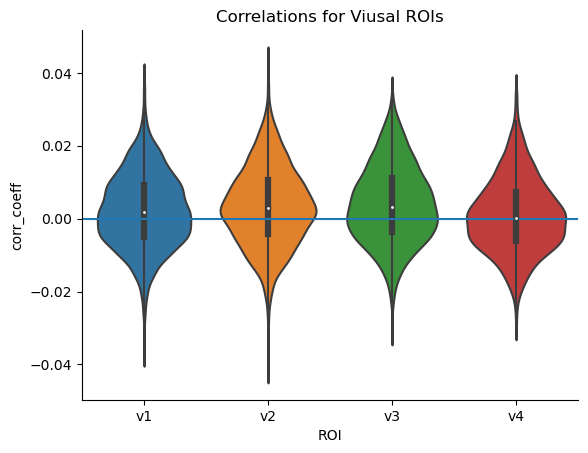

In [66]:
g = sns.violinplot(data = corr_df_viz, x = "ROI" , y = "corr_coeff")
sns.despine()
g.axhline(0)
g.set(title = 'Correlations for Viusal ROIs');

In [67]:
def concat_df_with_type(df_list , type_list):
    '''
    Concatenate the corr dataframes such that they each have a colunn 'type' which contains the type of the data. 
    Such as DeepGaze, edge, lumninance, etc.
    
    '''
    dfs_with_type = [df.assign(type=corr_type) for df, corr_type in zip(df_list, type_list)]
    df_main = pd.concat(dfs_with_type, ignore_index=True)
    
    return df_main

In [68]:
corr_df_faces = generate_corr_full(subject = 2, roi_list = floc_faces_roi_list, S_mat = S_mat_averaged)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [71]:
corr_df_words = generate_corr_full(subject = 2, roi_list = floc_words_roi_list, S_mat = S_mat_averaged)

Computing correlation for eba

Computing correlation for fba1

fba1 not found, skipping
Computing correlation for fba2



In [72]:
corr_df_places = generate_corr_full(subject = 2, roi_list = floc_places_roi_list, S_mat = S_mat_averaged)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [73]:
corr_df_bodies = generate_corr_full(subject = 2, roi_list = floc_bodies_roi_list, S_mat = S_mat_averaged)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [74]:
corr_df_list_a = generate_corr_full(subject =2 , roi_list = list_a, S_mat = S_mat_averaged)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [75]:
corr_df_list_b = generate_corr_full(subject =2, roi_list = list_b, S_mat = S_mat_averaged)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



In [76]:
corr_dfs_deepgaze = {} 

corr_dfs_deepgaze['viz'] = corr_df_viz
corr_dfs_deepgaze['faces'] = corr_df_faces
corr_dfs_deepgaze['words'] = corr_df_words
corr_dfs_deepgaze['places']= corr_df_places
corr_dfs_deepgaze['bodies']= corr_df_bodies
corr_dfs_deepgaze['list_a']= corr_df_list_a
corr_dfs_deepgaze['list_b']= corr_df_list_b

In [77]:
pickle.dump(corr_dfs_deepgaze, open(f"{DATA_PATH}/corr_dictionaries/corr_dfs_deepgaze_subject2.pkl", "wb"))

## Edges

In [79]:
S_mat_edges_averaged = gen_avg_sal_maps_subjectwise(subject = 2, S_mat_type = 'edges', img_indices = img_indices_subj2)

 92%|█████████▏| 27453/30000 [00:50<00:01, 2162.39it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:50<00:00, 589.55it/s] 


In [81]:
corr_df_viz_edges = generate_corr_full(subject = 2, roi_list = viz_roi_list, S_mat= S_mat_edges_averaged)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [82]:
corr_df_faces_edges = generate_corr_full(subject = 2, roi_list = floc_faces_roi_list,  S_mat = S_mat_edges_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [83]:
corr_df_words_edges = generate_corr_full(subject = 2, roi_list = floc_words_roi_list, S_mat = S_mat_edges_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

fba1 not found, skipping
Computing correlation for fba2



In [84]:
corr_df_places_edges = generate_corr_full(subject = 2, roi_list =floc_places_roi_list,  S_mat = S_mat_edges_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [85]:
corr_df_bodies_edges = generate_corr_full(subject = 2, roi_list = floc_bodies_roi_list,  S_mat = S_mat_edges_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [86]:
corr_df_listA_edges = generate_corr_full(subject = 2, roi_list = list_a, S_mat =  S_mat_edges_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [87]:
corr_df_listB_edges = generate_corr_full(subject = 2, roi_list =list_b,  S_mat = S_mat_edges_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



In [88]:
corr_dfs_edges = {} 

corr_dfs_edges['viz'] = corr_df_viz_edges
corr_dfs_edges['faces'] = corr_df_faces_edges
corr_dfs_edges['words'] = corr_df_words_edges
corr_dfs_edges['places']= corr_df_places_edges
corr_dfs_edges['bodies']= corr_df_bodies_edges
corr_dfs_edges['list_a']= corr_df_listA_edges
corr_dfs_edges['list_b']= corr_df_listB_edges

pickle.dump(corr_dfs_edges, open(f"{DATA_PATH}/corr_dictionaries/corr_dfs_edges_subject2.pkl", "wb"))

## Luminance and Saturation

In [91]:
S_mat_saturation_averaged = gen_avg_sal_maps_subjectwise(subject = 2, S_mat_type = 'saturation', img_indices = img_indices_subj2)
S_mat_luminance_averaged = gen_avg_sal_maps_subjectwise(subject = 2, S_mat_type = 'luminance', img_indices = img_indices_subj2)

100%|██████████| 30000/30000 [00:34<00:00, 871.76it/s] 


In [92]:
corr_df_viz_saturation = generate_corr_full(subject =2, roi_list = viz_roi_list, S_mat = S_mat_saturation_averaged, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [93]:
corr_df_viz_luminance = generate_corr_full(subject =2, roi_list = viz_roi_list, S_mat = S_mat_luminance_averaged, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [94]:
corr_df_faces_saturation = generate_corr_full(subject =2, roi_list = floc_faces_roi_list, S_mat = S_mat_saturation_averaged, print_log = False)


Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [95]:
corr_df_faces_luminance = generate_corr_full(subject =2, roi_list = floc_faces_roi_list, S_mat = S_mat_luminance_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [96]:
corr_df_bodies_saturation = generate_corr_full(subject =2, roi_list = floc_bodies_roi_list, S_mat = S_mat_saturation_averaged, print_log = False)


Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [97]:
corr_df_bodies_luminance = generate_corr_full(subject =2, roi_list = floc_bodies_roi_list, S_mat = S_mat_luminance_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [98]:
corr_df_places_saturation = generate_corr_full(subject =2, roi_list = floc_places_roi_list, S_mat = S_mat_saturation_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [99]:
corr_df_places_luminance = generate_corr_full(subject =2, roi_list = floc_places_roi_list, S_mat = S_mat_luminance_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [100]:
corr_df_words_luminance = generate_corr_full(subject =2, roi_list = floc_words_roi_list, S_mat = S_mat_luminance_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

fba1 not found, skipping
Computing correlation for fba2



In [101]:
corr_df_words_saturation = generate_corr_full(subject =2, roi_list = floc_words_roi_list, S_mat = S_mat_saturation_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

fba1 not found, skipping
Computing correlation for fba2



In [102]:
corr_df_listA_saturation = generate_corr_full(subject =2, roi_list = list_a, S_mat = S_mat_saturation_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [103]:
corr_df_listA_luminance = generate_corr_full(subject =2, roi_list = list_a, S_mat = S_mat_luminance_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [104]:
corr_df_listB_saturation = generate_corr_full(subject =2, roi_list = list_b, S_mat = S_mat_saturation_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



In [106]:
corr_df_listB_luminance = generate_corr_full(subject =2, roi_list = list_b, S_mat = S_mat_luminance_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



In [107]:
corr_dfs_saturation = {} 

corr_dfs_saturation['viz'] = corr_df_viz_saturation
corr_dfs_saturation['faces'] = corr_df_faces_saturation
corr_dfs_saturation['words'] = corr_df_words_saturation
corr_dfs_saturation['places']= corr_df_places_saturation
corr_dfs_saturation['bodies']= corr_df_bodies_saturation
corr_dfs_saturation['list_a']= corr_df_listA_saturation
corr_dfs_saturation['list_b']= corr_df_listB_saturation

pickle.dump(corr_dfs_saturation, open(f"{DATA_PATH}/corr_dictionaries/corr_dfs_saturation_subject2.pkl", "wb"))

In [108]:
corr_dfs_luminance = {} 

corr_dfs_luminance['viz'] = corr_df_viz_luminance
corr_dfs_luminance['faces'] = corr_df_faces_luminance
corr_dfs_luminance['words'] = corr_df_words_luminance
corr_dfs_luminance['places']= corr_df_places_luminance
corr_dfs_luminance['bodies']= corr_df_bodies_luminance
corr_dfs_luminance['list_a']= corr_df_listA_luminance
corr_dfs_luminance['list_b']= corr_df_listB_luminance

pickle.dump(corr_dfs_luminance, open(f"{DATA_PATH}/corr_dictionaries/corr_dfs_luminance_subject2.pkl", "wb"))

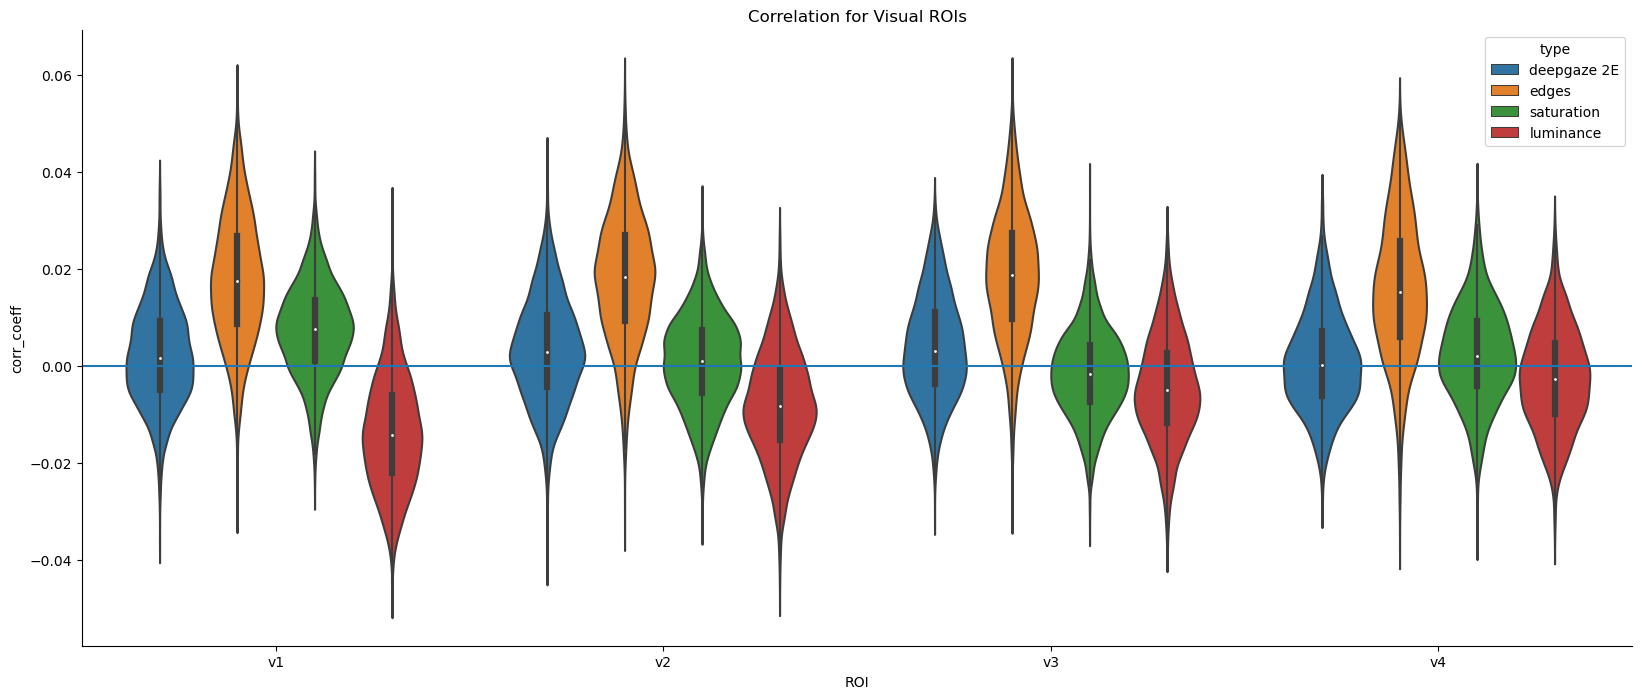

In [110]:
plt.figure(figsize=(20, 8))

plot_corr_violinplot(df = concat_df_with_type(
                          df_list = [corr_df_viz, corr_df_viz_edges, corr_df_viz_saturation, corr_df_viz_luminance],
                        type_list = ["deepgaze 2E", "edges", "saturation", "luminance"]),                   
                            title = "Correlation for Visual ROIs",
                            palette = "tab10")

## IttiKoch


In [113]:
S_mat_ittikoch_averaged  = gen_avg_sal_maps_subjectwise(subject= 2, S_mat_type= 'ittikoch', img_indices=img_indices_subj2)

 92%|█████████▏| 27589/30000 [03:19<00:02, 945.23it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [03:19<00:00, 150.48it/s] 


In [115]:
corr_df_viz_itti = generate_corr_full(subject = 2, roi_list = viz_roi_list, S_mat = S_mat_ittikoch_averaged, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [116]:
corr_df_faces_itti = generate_corr_full(subject = 2, roi_list = floc_faces_roi_list,S_mat =  S_mat_ittikoch_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [117]:
corr_df_bodies_itti = generate_corr_full(subject = 2,roi_list = floc_bodies_roi_list, S_mat = S_mat_ittikoch_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [118]:
corr_df_places_itti = generate_corr_full(subject = 2,roi_list = floc_places_roi_list,S_mat =  S_mat_ittikoch_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [119]:
corr_df_words_itti = generate_corr_full(subject = 2,roi_list = floc_words_roi_list, S_mat = S_mat_ittikoch_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

fba1 not found, skipping
Computing correlation for fba2



In [120]:
corr_df_listA_itti = generate_corr_full(subject = 2,roi_list = list_a, S_mat = S_mat_ittikoch_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [121]:
corr_df_listB_itti = generate_corr_full(subject = 2,roi_list = list_b,S_mat =  S_mat_ittikoch_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



In [122]:
corr_dfs_ittikoch = {} 

corr_dfs_ittikoch['viz'] = corr_df_viz_itti
corr_dfs_ittikoch['faces'] = corr_df_faces_itti
corr_dfs_ittikoch['words'] = corr_df_words_itti
corr_dfs_ittikoch['places']= corr_df_places_itti
corr_dfs_ittikoch['bodies']= corr_df_bodies_itti
corr_dfs_ittikoch['list_a']= corr_df_listA_itti
corr_dfs_ittikoch['list_b']= corr_df_listB_itti

pickle.dump(corr_dfs_ittikoch, open(f"{DATA_PATH}/corr_dictionaries/corr_dfs_ittikoch_subject2.pkl", "wb"))

## ICF and DG1, 

In [124]:
S_mat_dg1_averaged  = gen_avg_sal_maps_subjectwise(subject= 2, S_mat_type= 'deepgaze1', img_indices=img_indices_subj2)

 90%|█████████ | 27093/30000 [00:11<00:00, 6882.24it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:12<00:00, 2497.50it/s]


In [125]:
corr_df_listB_itti = generate_corr_full(subject = 2,roi_list = list_b,S_mat =  S_mat_ittikoch_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



In [126]:
corr_df_viz_dg1 = generate_corr_full(subject = 2, roi_list = viz_roi_list,S_mat = S_mat_dg1_averaged, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [127]:
corr_df_faces_dg1 = generate_corr_full(subject = 2,roi_list = floc_faces_roi_list,S_mat = S_mat_dg1_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [128]:
corr_df_bodies_dg1 = generate_corr_full(subject = 2,roi_list = floc_bodies_roi_list,S_mat = S_mat_dg1_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [129]:
corr_df_places_dg1 = generate_corr_full(subject = 2,roi_list = floc_places_roi_list,S_mat = S_mat_dg1_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [130]:
corr_df_words_dg1 = generate_corr_full(subject = 2,roi_list = floc_words_roi_list,S_mat = S_mat_dg1_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

fba1 not found, skipping
Computing correlation for fba2



In [131]:
corr_df_listA_dg1 = generate_corr_full(subject = 2,roi_list = list_a, S_mat = S_mat_dg1_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [132]:
corr_df_listB_dg1 = generate_corr_full(subject = 2,roi_list = list_b,S_mat =  S_mat_dg1_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



In [133]:
corr_dfs_dg1 = {} 

corr_dfs_dg1['viz'] = corr_df_viz_dg1
corr_dfs_dg1['faces'] = corr_df_faces_dg1
corr_dfs_dg1['words'] = corr_df_words_dg1
corr_dfs_dg1['places']= corr_df_places_dg1
corr_dfs_dg1['bodies']= corr_df_bodies_dg1
corr_dfs_dg1['list_a']= corr_df_listA_dg1
corr_dfs_dg1['list_b']= corr_df_listB_dg1

pickle.dump(corr_dfs_dg1, open(f"{DATA_PATH}/corr_dictionaries/corr_dfs_dg1_subject2.pkl", "wb"))

# ICF

In [134]:
S_mat_icf_averaged  = gen_avg_sal_maps_subjectwise(subject= 2, S_mat_type= 'icf', img_indices=img_indices_subj2)

 92%|█████████▏| 27622/30000 [00:30<00:00, 3375.59it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:30<00:00, 984.56it/s] 


In [135]:
corr_df_viz_icf = generate_corr_full(subject = 2, roi_list = viz_roi_list,S_mat =S_mat_icf_averaged, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [136]:
corr_df_faces_icf = generate_corr_full(subject = 2, roi_list = floc_faces_roi_list, S_mat =S_mat_icf_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [137]:
corr_df_bodies_icf = generate_corr_full(subject = 2, roi_list = floc_bodies_roi_list, S_mat =S_mat_icf_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [138]:
corr_df_places_icf = generate_corr_full(subject = 2, roi_list = floc_places_roi_list, S_mat =S_mat_icf_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [139]:
corr_df_words_icf = generate_corr_full(subject = 2, roi_list = floc_words_roi_list, S_mat =S_mat_icf_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

fba1 not found, skipping
Computing correlation for fba2



In [140]:
corr_df_listA_icf = generate_corr_full(subject = 2, roi_list = list_a,  S_mat = S_mat_icf_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [141]:
corr_df_listB_icf = generate_corr_full(subject = 2, roi_list = list_b, S_mat = S_mat_icf_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



In [142]:
corr_dfs_icf = {} 

corr_dfs_icf['viz'] = corr_df_viz_icf
corr_dfs_icf['faces'] = corr_df_faces_icf
corr_dfs_icf['words'] = corr_df_words_icf
corr_dfs_icf['places']= corr_df_places_icf
corr_dfs_icf['bodies']= corr_df_bodies_icf
corr_dfs_icf['list_a']= corr_df_listA_icf
corr_dfs_icf['list_b']= corr_df_listB_icf

pickle.dump(corr_dfs_icf, open(f"{DATA_PATH}/corr_dictionaries/corr_dfs_icf_subject2.pkl", "wb"))

# DG2

In [143]:
S_mat_dg2_averaged  = gen_avg_sal_maps_subjectwise(subject= 2, S_mat_type= 'deepgaze2', img_indices=img_indices_subj2)

 92%|█████████▏| 27679/30000 [00:31<00:00, 3450.06it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:31<00:00, 944.29it/s] 


In [144]:
corr_df_viz_dg2 = generate_corr_full(subject= 2, roi_list = viz_roi_list,S_mat = S_mat_dg2_averaged, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [145]:
corr_df_faces_dg2 = generate_corr_full(subject = 2,roi_list = floc_faces_roi_list,S_mat =S_mat_dg2_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [146]:
corr_df_bodies_dg2 = generate_corr_full(subject = 2,roi_list = floc_bodies_roi_list,S_mat =S_mat_dg2_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [147]:
corr_df_places_dg2 = generate_corr_full(subject = 2,roi_list =floc_places_roi_list,S_mat =S_mat_dg2_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [148]:
corr_df_words_dg2 = generate_corr_full(subject = 2,roi_list =floc_words_roi_list,S_mat =S_mat_dg2_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

fba1 not found, skipping
Computing correlation for fba2



In [149]:
corr_df_listA_dg2 = generate_corr_full(subject = 2,roi_list =list_a, S_mat =S_mat_dg2_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [150]:
corr_df_listB_dg2 = generate_corr_full(subject = 2,roi_list = list_b, S_mat =S_mat_dg2_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



In [151]:
corr_dfs_dg2 = {} 

corr_dfs_dg2['viz'] = corr_df_viz_dg2
corr_dfs_dg2['faces'] = corr_df_faces_dg2
corr_dfs_dg2['words'] = corr_df_words_dg2
corr_dfs_dg2['places']= corr_df_places_dg2
corr_dfs_dg2['bodies']= corr_df_bodies_dg2
corr_dfs_dg2['list_a']= corr_df_listA_dg2
corr_dfs_dg2['list_b']= corr_df_listB_dg2

pickle.dump(corr_dfs_dg2, open(f"{DATA_PATH}/corr_dictionaries/corr_dfs_dg2_subject2.pkl", "wb"))

# ResNet Stage 4 

In [153]:
S_mat_stage4_averaged = gen_avg_sal_maps_subjectwise(subject= 2, S_mat_type= 'resnet-4',img_indices=img_indices_subj2 )

 91%|█████████ | 27300/30000 [00:30<00:00, 3034.83it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:30<00:00, 970.18it/s] 


In [154]:
corr_df_viz_stage4 = generate_corr_full(subject = 2, roi_list = viz_roi_list,S_mat = S_mat_stage4_averaged, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [155]:
corr_df_faces_stage4 = generate_corr_full(subject = 2, roi_list = floc_faces_roi_list,S_mat = S_mat_stage4_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [156]:
corr_df_bodies_stage4 = generate_corr_full(subject = 2,roi_list =  floc_bodies_roi_list,S_mat = S_mat_stage4_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [157]:
corr_df_places_stage4 = generate_corr_full(subject = 2,roi_list = floc_places_roi_list,S_mat = S_mat_stage4_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [158]:
corr_df_words_stage4 = generate_corr_full(subject = 2,roi_list = floc_words_roi_list,S_mat = S_mat_stage4_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

fba1 not found, skipping
Computing correlation for fba2



In [159]:
corr_df_listA_stage4 = generate_corr_full(subject = 2,roi_list = list_a, S_mat = S_mat_stage4_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [160]:
corr_df_listB_stage4 = generate_corr_full(subject = 2,roi_list = list_b, S_mat = S_mat_stage4_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



In [161]:
corr_dfs_stage4 = {} 

corr_dfs_stage4['viz'] = corr_df_viz_stage4
corr_dfs_stage4['faces'] = corr_df_faces_stage4
corr_dfs_stage4['words'] = corr_df_words_stage4
corr_dfs_stage4['places']= corr_df_places_stage4
corr_dfs_stage4['bodies']= corr_df_bodies_stage4
corr_dfs_stage4['list_a']= corr_df_listA_stage4
corr_dfs_stage4['list_b']= corr_df_listB_stage4

pickle.dump(corr_dfs_stage4, open(f"{DATA_PATH}/corr_dictionaries/corr_dfs_stage4_subject2.pkl", "wb"))

# GBVS 

In [ ]:
S_mat_gbvs_averaged = gen_avg_sal_maps_subjectwise(subject= 2, S_mat_type= 'gbvs',img_indices=img_indices_subj2 )

 50%|████▉     | 14973/30000 [02:34<01:25, 175.82it/s]

In [164]:
corr_df_viz_gbvs = generate_corr_full(subject = 2, roi_list = viz_roi_list, S_mat = S_mat_gbvs_averaged, print_log = False)


Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [165]:
corr_df_faces_gbvs = generate_corr_full(subject = 2, roi_list = floc_faces_roi_list,S_mat =S_mat_gbvs_averaged, print_log = False)


Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [166]:
corr_df_bodies_gbvs = generate_corr_full(subject = 2,roi_list = floc_bodies_roi_list,S_mat =S_mat_gbvs_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [167]:
corr_df_places_gbvs = generate_corr_full(subject = 2,roi_list = floc_places_roi_list,S_mat =S_mat_gbvs_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [168]:
corr_df_words_gbvs = generate_corr_full(subject = 2,roi_list = floc_words_roi_list,S_mat =S_mat_gbvs_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

fba1 not found, skipping
Computing correlation for fba2



In [169]:
corr_df_listA_gbvs = generate_corr_full(subject = 2,roi_list = list_a,S_mat = S_mat_gbvs_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [170]:
corr_df_listB_gbvs = generate_corr_full(subject = 2,roi_list = list_b, S_mat =S_mat_gbvs_averaged, print_log = False)


Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



In [171]:
corr_dfs_gbvs = {} 

corr_dfs_gbvs['viz'] = corr_df_viz_gbvs
corr_dfs_gbvs['faces'] = corr_df_faces_gbvs
corr_dfs_gbvs['words'] = corr_df_words_gbvs
corr_dfs_gbvs['places']= corr_df_places_gbvs
corr_dfs_gbvs['bodies']= corr_df_bodies_gbvs
corr_dfs_gbvs['list_a']= corr_df_listA_gbvs
corr_dfs_gbvs['list_b']= corr_df_listB_gbvs

pickle.dump(corr_dfs_gbvs, open(f"{DATA_PATH}/corr_dictionaries/corr_dfs_gbvs.pkl", "wb"))

In [172]:
def plot_mean_and_ci(df, title, hue_order = None,  palette = "tab10" ):

    # Use the `hue` parameter to separate data by 'type'
    plt.figure(figsize=(20, 8)) 
    sns.barplot(data=df, x='ROI', y='corr_coeff', hue='type', ci=95, hue_order = hue_order, palette = palette)

    # Customize the plot labels and title
    plt.xlabel('ROI')
    plt.ylabel('Correlation coefficient')
    plt.title(title)
    file_name = title.replace(" ","_")
    SAVE_PATH = f"/gpfs01/bartels/user/hbhatnagar/nsd-static-saliency/results/{file_name}"
    plt.savefig(f"{SAVE_PATH}.svg")
    plt.legend( title='Model', ncol = 2)

<Figure size 2000x800 with 0 Axes>

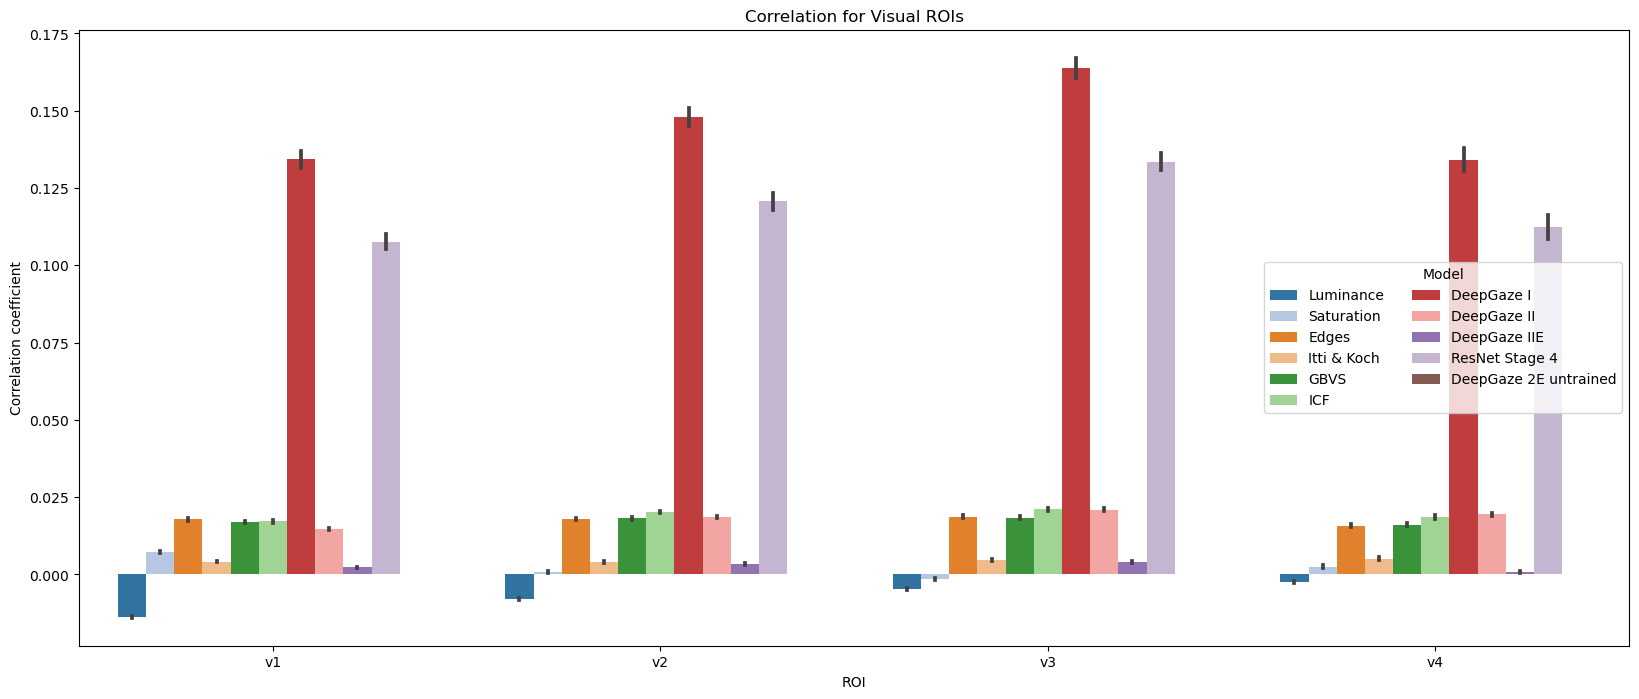

In [173]:
plt.figure(figsize=(20, 8))

plot_mean_and_ci(df = concat_df_with_type(
                          df_list = [corr_df_viz_stage4,
                                     corr_df_viz, corr_df_viz_itti, corr_df_viz_gbvs, corr_df_viz_icf,
                                     corr_df_viz_dg2,corr_df_viz_dg1, corr_df_viz_edges, corr_df_viz_saturation, corr_df_viz_luminance],
                        type_list = ["ResNet Stage 4",
                                    "DeepGaze IIE", "Itti & Koch" ,"GBVS","ICF",
                                     "DeepGaze II","DeepGaze I", "Edges", "Saturation", "Luminance", "DeepGaze 2E untrained"]), 
                         hue_order = ['Luminance', 'Saturation', 'Edges', 'Itti & Koch', 'GBVS', 'ICF', 'DeepGaze I', 'DeepGaze II', 'DeepGaze IIE',
                                      "ResNet Stage 4","DeepGaze 2E untrained"],
                            title = "Correlation for Visual ROIs",
                 
                            palette = "tab20")

<Figure size 2000x800 with 0 Axes>

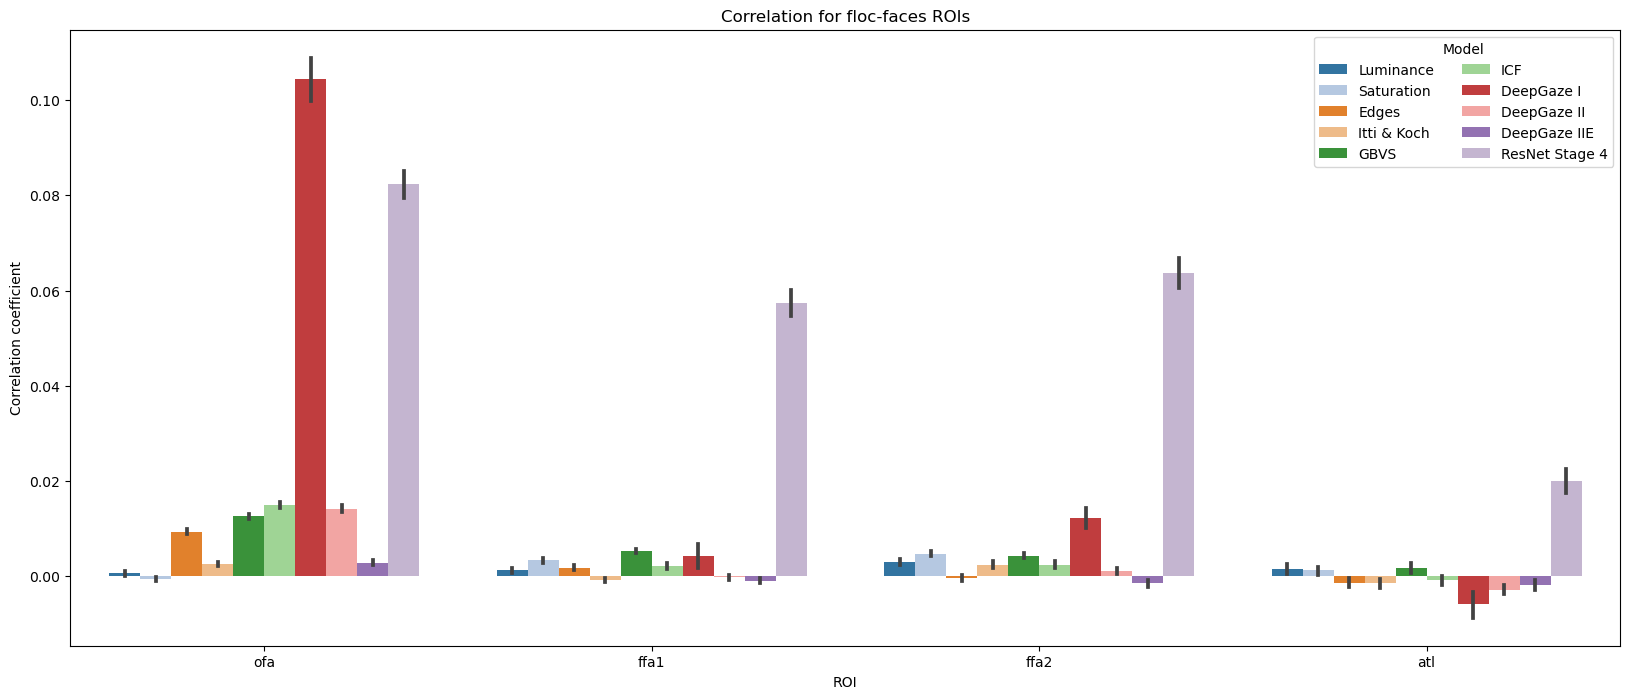

In [174]:
plt.figure(figsize=(20, 8))

plot_mean_and_ci(df = concat_df_with_type(
                          df_list = [corr_df_faces_stage4,
                                     corr_df_faces, corr_df_faces_itti, corr_df_faces_gbvs, corr_df_faces_icf, 
                                     corr_df_faces_dg2, corr_df_faces_dg1, corr_df_faces_edges, corr_df_faces_saturation, corr_df_faces_luminance],
                         type_list = ["ResNet Stage 4",
                                    "DeepGaze IIE", "Itti & Koch" ,"GBVS","ICF",
                                     "DeepGaze II","DeepGaze I", "Edges", "Saturation", "Luminance"]), 
                         hue_order = ['Luminance', 'Saturation', 'Edges', 'Itti & Koch', 'GBVS', 'ICF', 'DeepGaze I', 'DeepGaze II', 'DeepGaze IIE',
                                      "ResNet Stage 4"],
                             title = "Correlation for floc-faces ROIs",
                            palette = "tab20")

<Figure size 2000x800 with 0 Axes>

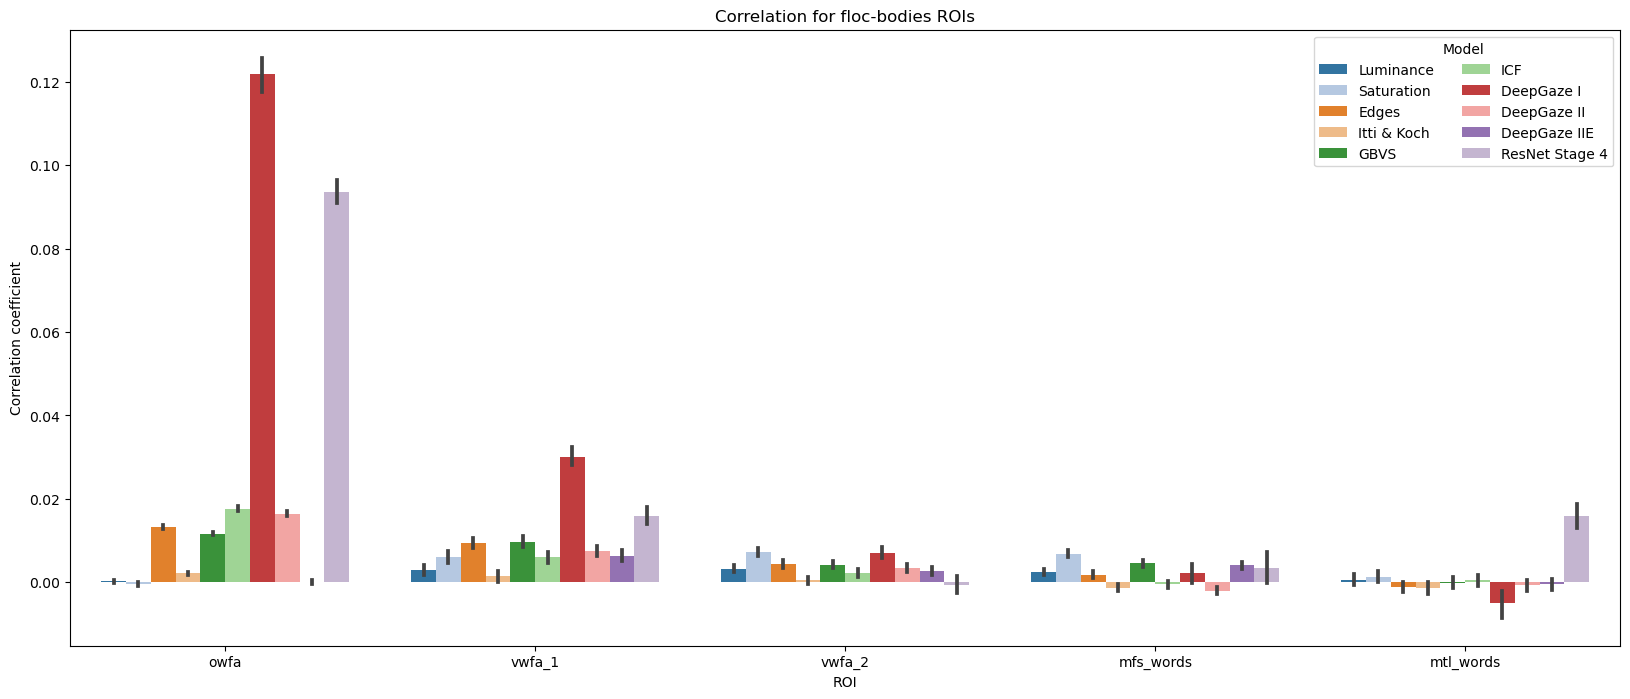

In [175]:
plt.figure(figsize=(20, 8))

plot_mean_and_ci(df = concat_df_with_type(
                          df_list = [corr_df_bodies_stage4,
                                     corr_df_bodies, corr_df_bodies_itti, corr_df_bodies_gbvs, corr_df_bodies_icf, 
                                     corr_df_bodies_dg2, corr_df_bodies_dg1 , corr_df_bodies_edges, corr_df_bodies_saturation, corr_df_bodies_luminance],
                        type_list = ["ResNet Stage 4",
                                    "DeepGaze IIE", "Itti & Koch" ,"GBVS","ICF",
                                     "DeepGaze II","DeepGaze I", "Edges", "Saturation", "Luminance"]), 
                         hue_order = ['Luminance', 'Saturation', 'Edges', 'Itti & Koch', 'GBVS', 'ICF', 'DeepGaze I', 'DeepGaze II', 'DeepGaze IIE',
                                      "ResNet Stage 4"],
                     
                            title = "Correlation for floc-bodies ROIs",
                            palette = "tab20")

<Figure size 2000x800 with 0 Axes>

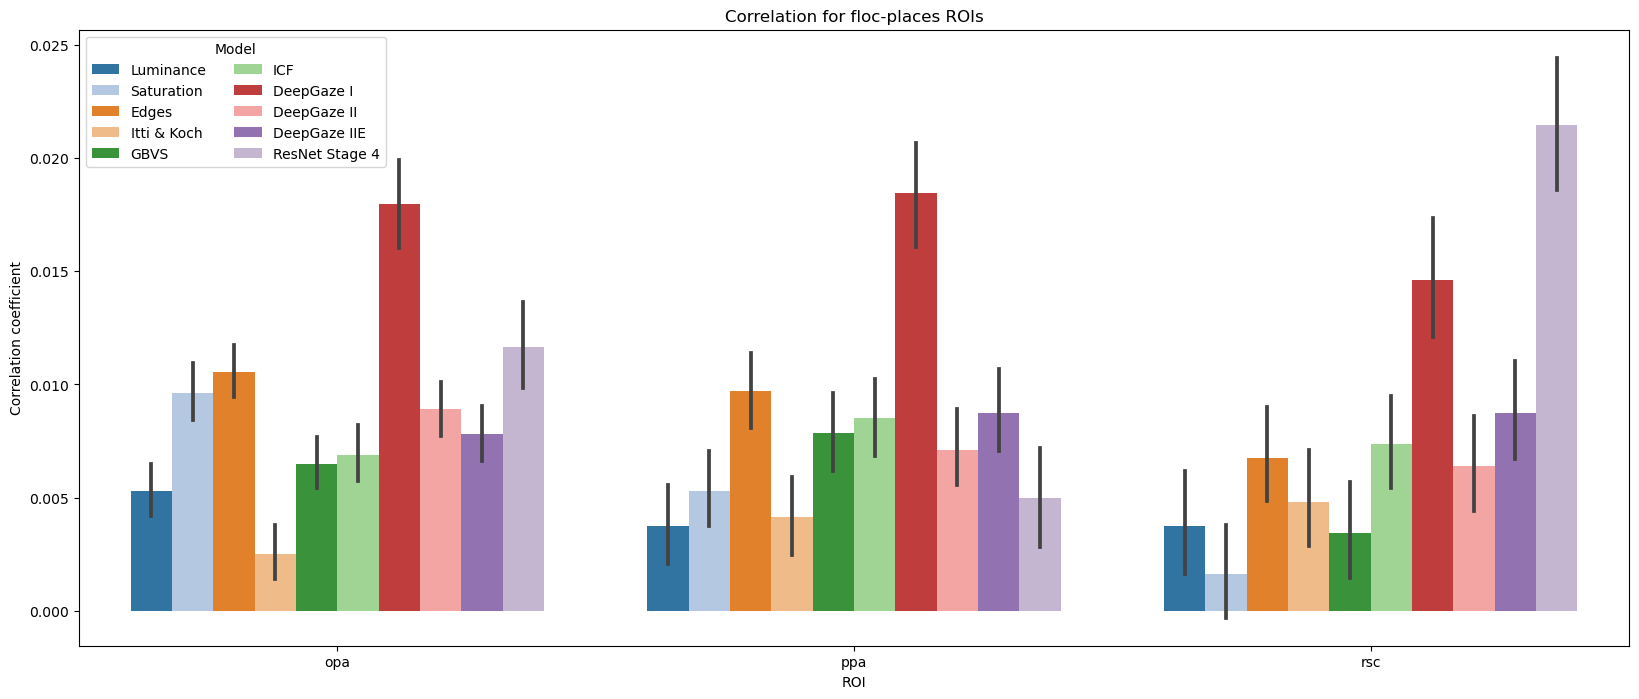

In [176]:
plt.figure(figsize=(20, 8))

plot_mean_and_ci(df = concat_df_with_type(
                          df_list = [corr_df_places_stage4,
                                     corr_df_places, corr_df_places_itti, corr_df_places_gbvs, corr_df_places_icf, 
                                     corr_df_places_dg2, corr_df_places_dg1, corr_df_places_edges, corr_df_places_saturation, corr_df_places_luminance],
                         type_list = ["ResNet Stage 4",
                                    "DeepGaze IIE", "Itti & Koch" ,"GBVS","ICF",
                                     "DeepGaze II","DeepGaze I", "Edges", "Saturation", "Luminance"]), 
                         hue_order = ['Luminance', 'Saturation', 'Edges', 'Itti & Koch', 'GBVS', 'ICF', 'DeepGaze I', 'DeepGaze II', 'DeepGaze IIE',
                                      "ResNet Stage 4"],                 
                            title = "Correlation for floc-places ROIs",
                            palette = "tab20")

<Figure size 2000x800 with 0 Axes>

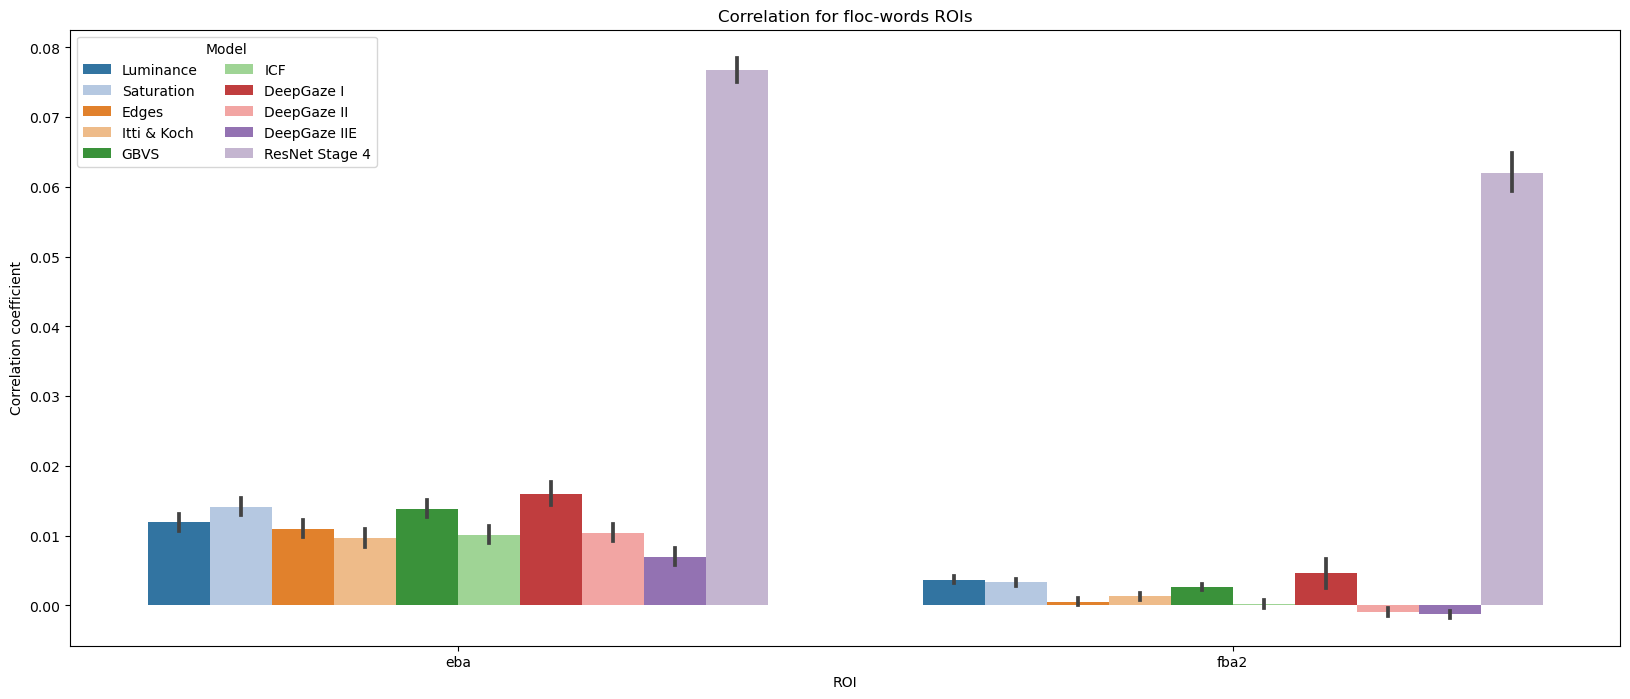

In [177]:
plt.figure(figsize=(20, 8))

plot_mean_and_ci(df = concat_df_with_type(
                          df_list = [corr_df_words_stage4,
                                     corr_df_words, corr_df_words_itti, corr_df_words_gbvs, corr_df_words_icf,
                                     corr_df_words_dg2, corr_df_words_dg1,corr_df_words_edges, corr_df_words_saturation, corr_df_words_luminance],
                        type_list = ["ResNet Stage 4",
                                    "DeepGaze IIE", "Itti & Koch" ,"GBVS","ICF",
                                     "DeepGaze II","DeepGaze I", "Edges", "Saturation", "Luminance"]), 
                         hue_order = ['Luminance', 'Saturation', 'Edges', 'Itti & Koch', 'GBVS', 'ICF', 'DeepGaze I', 'DeepGaze II', 'DeepGaze IIE',
                                      "ResNet Stage 4"],                 
                            title = "Correlation for floc-words ROIs",
                            palette = "tab20")

<Figure size 3000x1000 with 0 Axes>

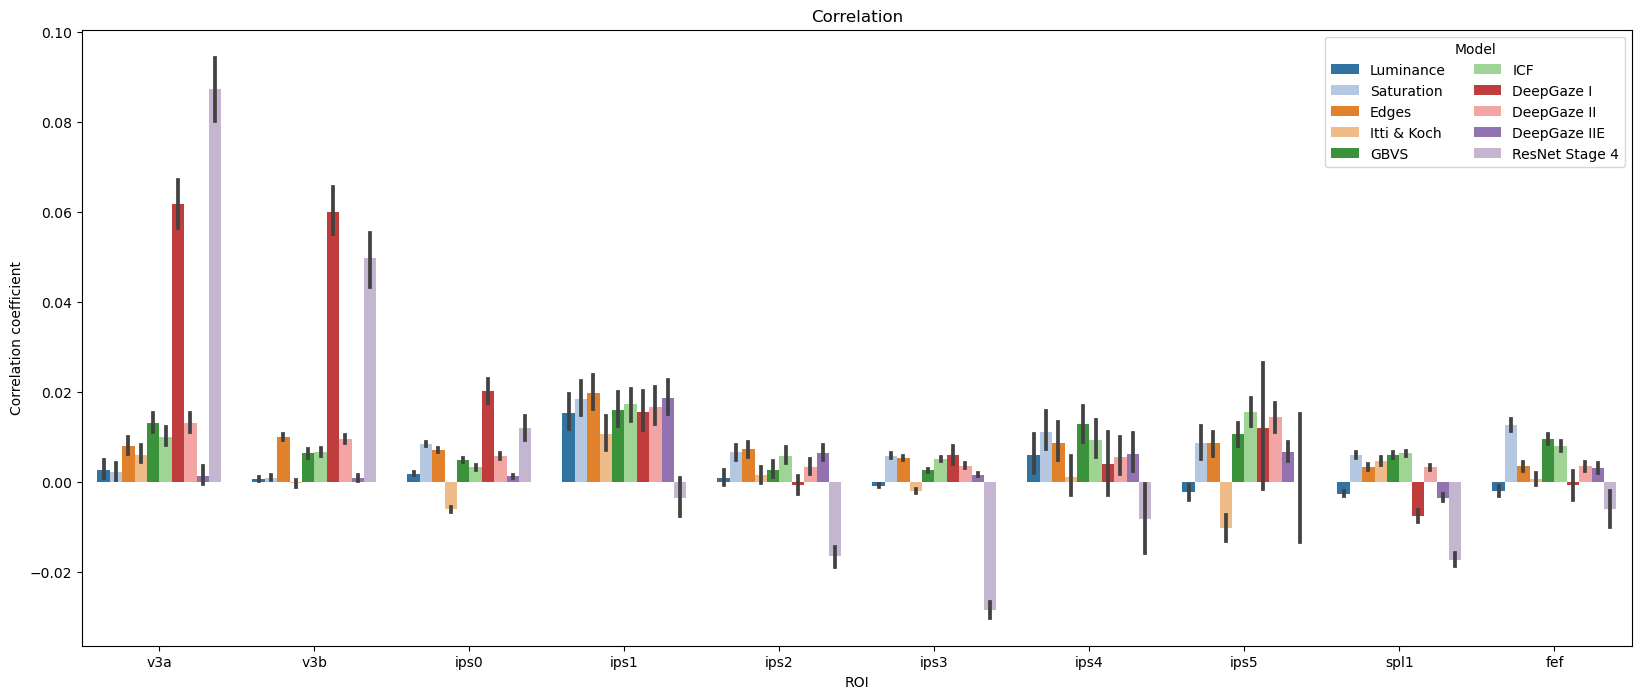

In [178]:
plt.figure(figsize=(30, 10))

plot_mean_and_ci(df = concat_df_with_type(
                          df_list = [corr_df_listA_stage4,
                                     corr_df_list_a, corr_df_listA_itti, corr_df_listA_gbvs, corr_df_listA_icf,
                                     corr_df_listA_dg2, corr_df_listA_dg1, corr_df_listA_edges, corr_df_listA_saturation, corr_df_listA_luminance],
                         type_list = ["ResNet Stage 4",
                                    "DeepGaze IIE", "Itti & Koch" ,"GBVS","ICF",
                                     "DeepGaze II","DeepGaze I", "Edges", "Saturation", "Luminance"]), 
                         hue_order = ['Luminance', 'Saturation', 'Edges', 'Itti & Koch', 'GBVS', 'ICF', 'DeepGaze I', 'DeepGaze II', 'DeepGaze IIE',
                                    "ResNet Stage 4"],         
                            title = "Correlation",
                            palette = "tab20")

<Figure size 2000x800 with 0 Axes>

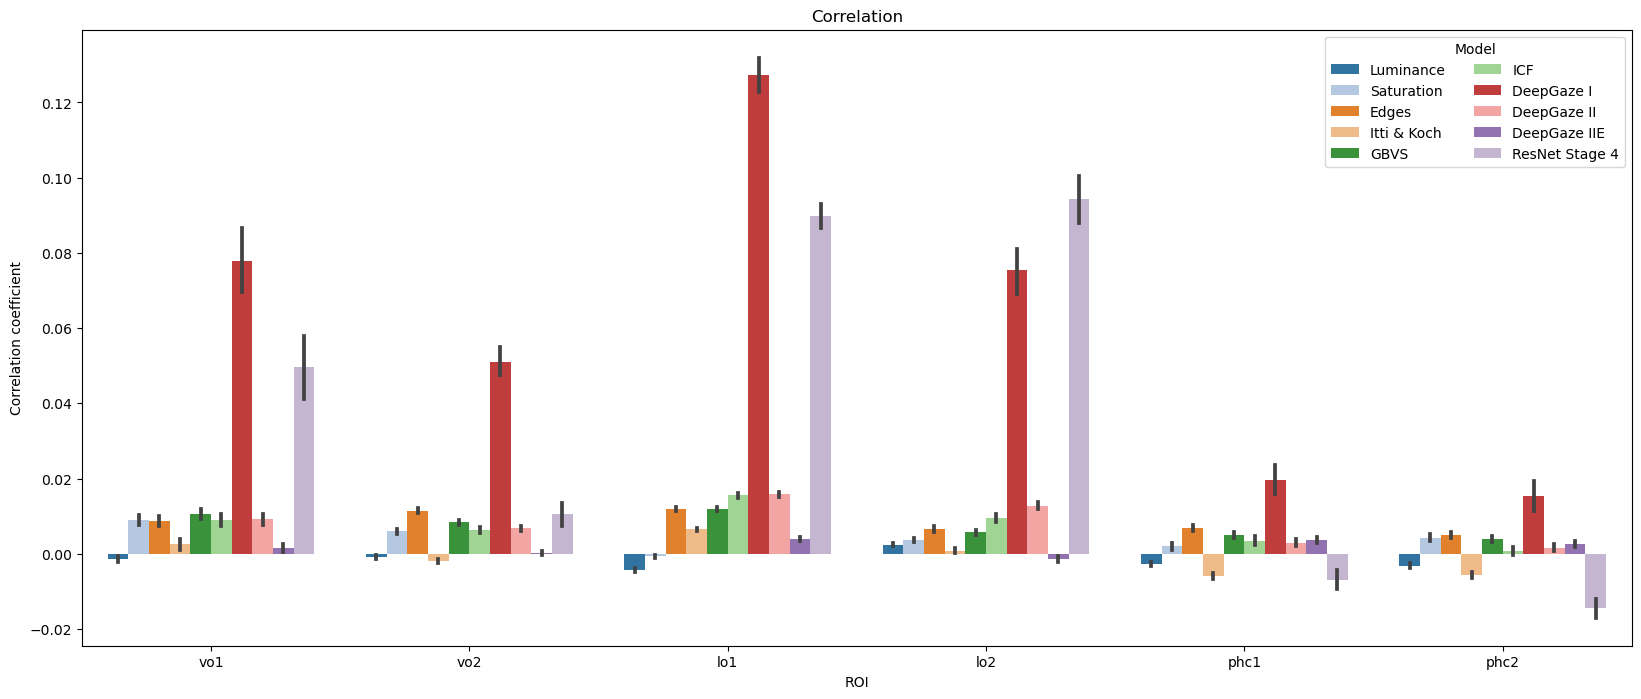

In [179]:
plt.figure(figsize=(20, 8))

plot_mean_and_ci(df = concat_df_with_type(
                          df_list = [corr_df_listB_stage4,
                                     corr_df_list_b, corr_df_listB_itti, corr_df_listB_gbvs, corr_df_listB_icf,
                                     corr_df_listB_dg2, corr_df_listB_dg1, corr_df_listB_edges, corr_df_listB_saturation, corr_df_listB_luminance],
                        type_list = ["ResNet Stage 4",
                                    "DeepGaze IIE", "Itti & Koch" ,"GBVS","ICF",
                                     "DeepGaze II","DeepGaze I", "Edges", "Saturation", "Luminance"]), 
                         hue_order = ['Luminance', 'Saturation', 'Edges', 'Itti & Koch', 'GBVS', 'ICF', 'DeepGaze I', 'DeepGaze II', 'DeepGaze IIE',
                                       "ResNet Stage 4"],         
                            title = "Correlation",
                            palette = "tab20")